In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

np.set_printoptions(suppress=True)

In [12]:
from scene import CircularCage, RectangularCage, SquareCage
from cell_group import PlaceCells, HeadDirectionCells

from dataloader import H5File
from trajectory_simulator import TrajectorySimulator

from model import VecNavModel, CrossEntropyLoss
from train import train_model
from util import print_mem, in_ipynb
import scipy
from scipy import stats
import torch


In [3]:
def mean_traj_dist(traj):
    xs, xs0 = traj[0].numpy(), traj[3].numpy()
    diff = np.mean(np.linalg.norm(xs[:, 0] - xs0, axis=1))
    mean_diff = np.array([np.linalg.norm(x - y, axis=1) for x, y in zip(xs[:, 1:], xs[:, :-1])]).mean()
    return diff, mean_diff

def mean_vel_over_time(traj, i=0):
    vs = traj[2].numpy().transpose(2, 1, 0)
    print("Mean ego_vels: ", (vs ** 2).mean(axis=(1, 2)))
    v = vs.mean(axis=2)
    plt.plot(np.arange(len(v[0, i:])), v[0, i:])
    plt.show()
    return v

def examine_batch(traj, crop=0):
    n = crop
    xs, ys = traj[0].reshape(-1, 2).transpose(1, 0).numpy()
    res = stats.binned_statistic_2d(xs, ys, np.ones_like(xs), bins=40, statistic="sum")[0]
    if n == 0:
        plt.imshow(res, cmap='jet')
    else:
        plt.imshow(res[n:-n, n:-n], cmap="jet")
    plt.axis("off")
    plt.show()
    return res

def plot_traj(traj):
    xs, hs, vels, xs0, hs0 = traj
    xs = xs.transpose(1, 0)
    hs = hs.transpose(1, 0)
    directions = torch.stack([xs, xs])[:, :, :]
    directions[1] += torch.cat([hs.cos(), hs.sin()]) * vels[:, 0] / 3
    directions = directions.transpose(0, 1)
    plt.plot(*directions.numpy())
    plt.plot(*xs.numpy())
    plt.show()

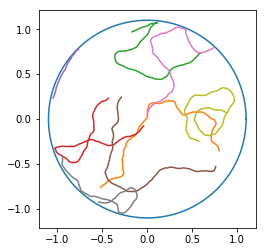

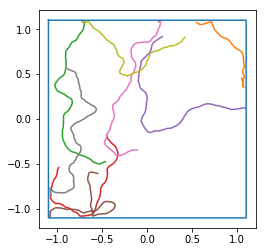

In [4]:
TrajectorySimulator(CircularCage(2.2)).plot_trajectories(N=8)

scene = SquareCage(2.2)
TS = TrajectorySimulator(scene, perimiter=0.03)
TS.plot_trajectories(N=8)

In [5]:
if False:
    traj_file = H5File('trajectories/new_traj.hdf5')
    TS.load_params(traj_file.attrs)
    TS.save(new_traj_f, N=10000)

In [6]:
filename = 'new_traj' # 'new_traj', 'deepmind_traj', 'trajectories_3'
dataset = H5File(f'trajectories/{filename}.hdf5').to_dataset()

In [7]:
dataloader = DataLoader(dataset, batch_size=10, num_workers=16)

Mean trajectory distance and velocity between steps:
(1.1499907, 0.019888056)

Trajectory with head direction and velocity:


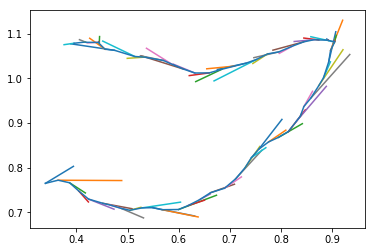


Density of 1000 paths over enclosure:


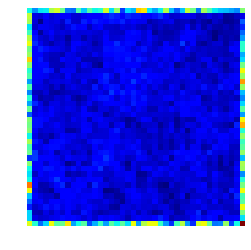

Mean ego_vels:  [0.02735298 0.9869875  0.01315353]


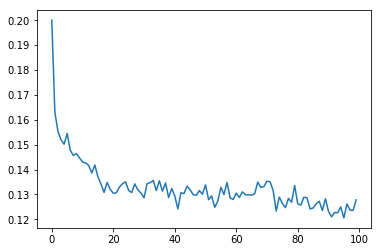

In [8]:
print(f'Mean trajectory distance and velocity between steps:\n{mean_traj_dist(dataset[:10000])}')

print('\nTrajectory with head direction and velocity:')
plot_traj(dataset[0])

print('\nDensity of 1000 paths over enclosure:')
_ = examine_batch(dataset[:1000], crop=0)

_ = mean_vel_over_time(dataset[:1000])

In [13]:
VNM = VecNavModel(12, 256, g_size=256, g_bias=False).cuda()
print(scene.height)

2.2


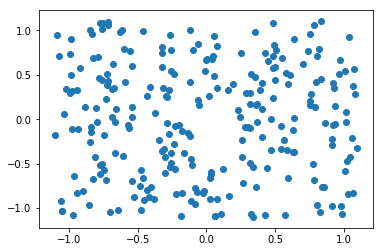

In [14]:
place_cells = PlaceCells(0.01, 256, scene)
hd_cells = HeadDirectionCells(20, 12)

epoch 0, mean loss 7.9275926551818845, std loss 0.050299038935559495


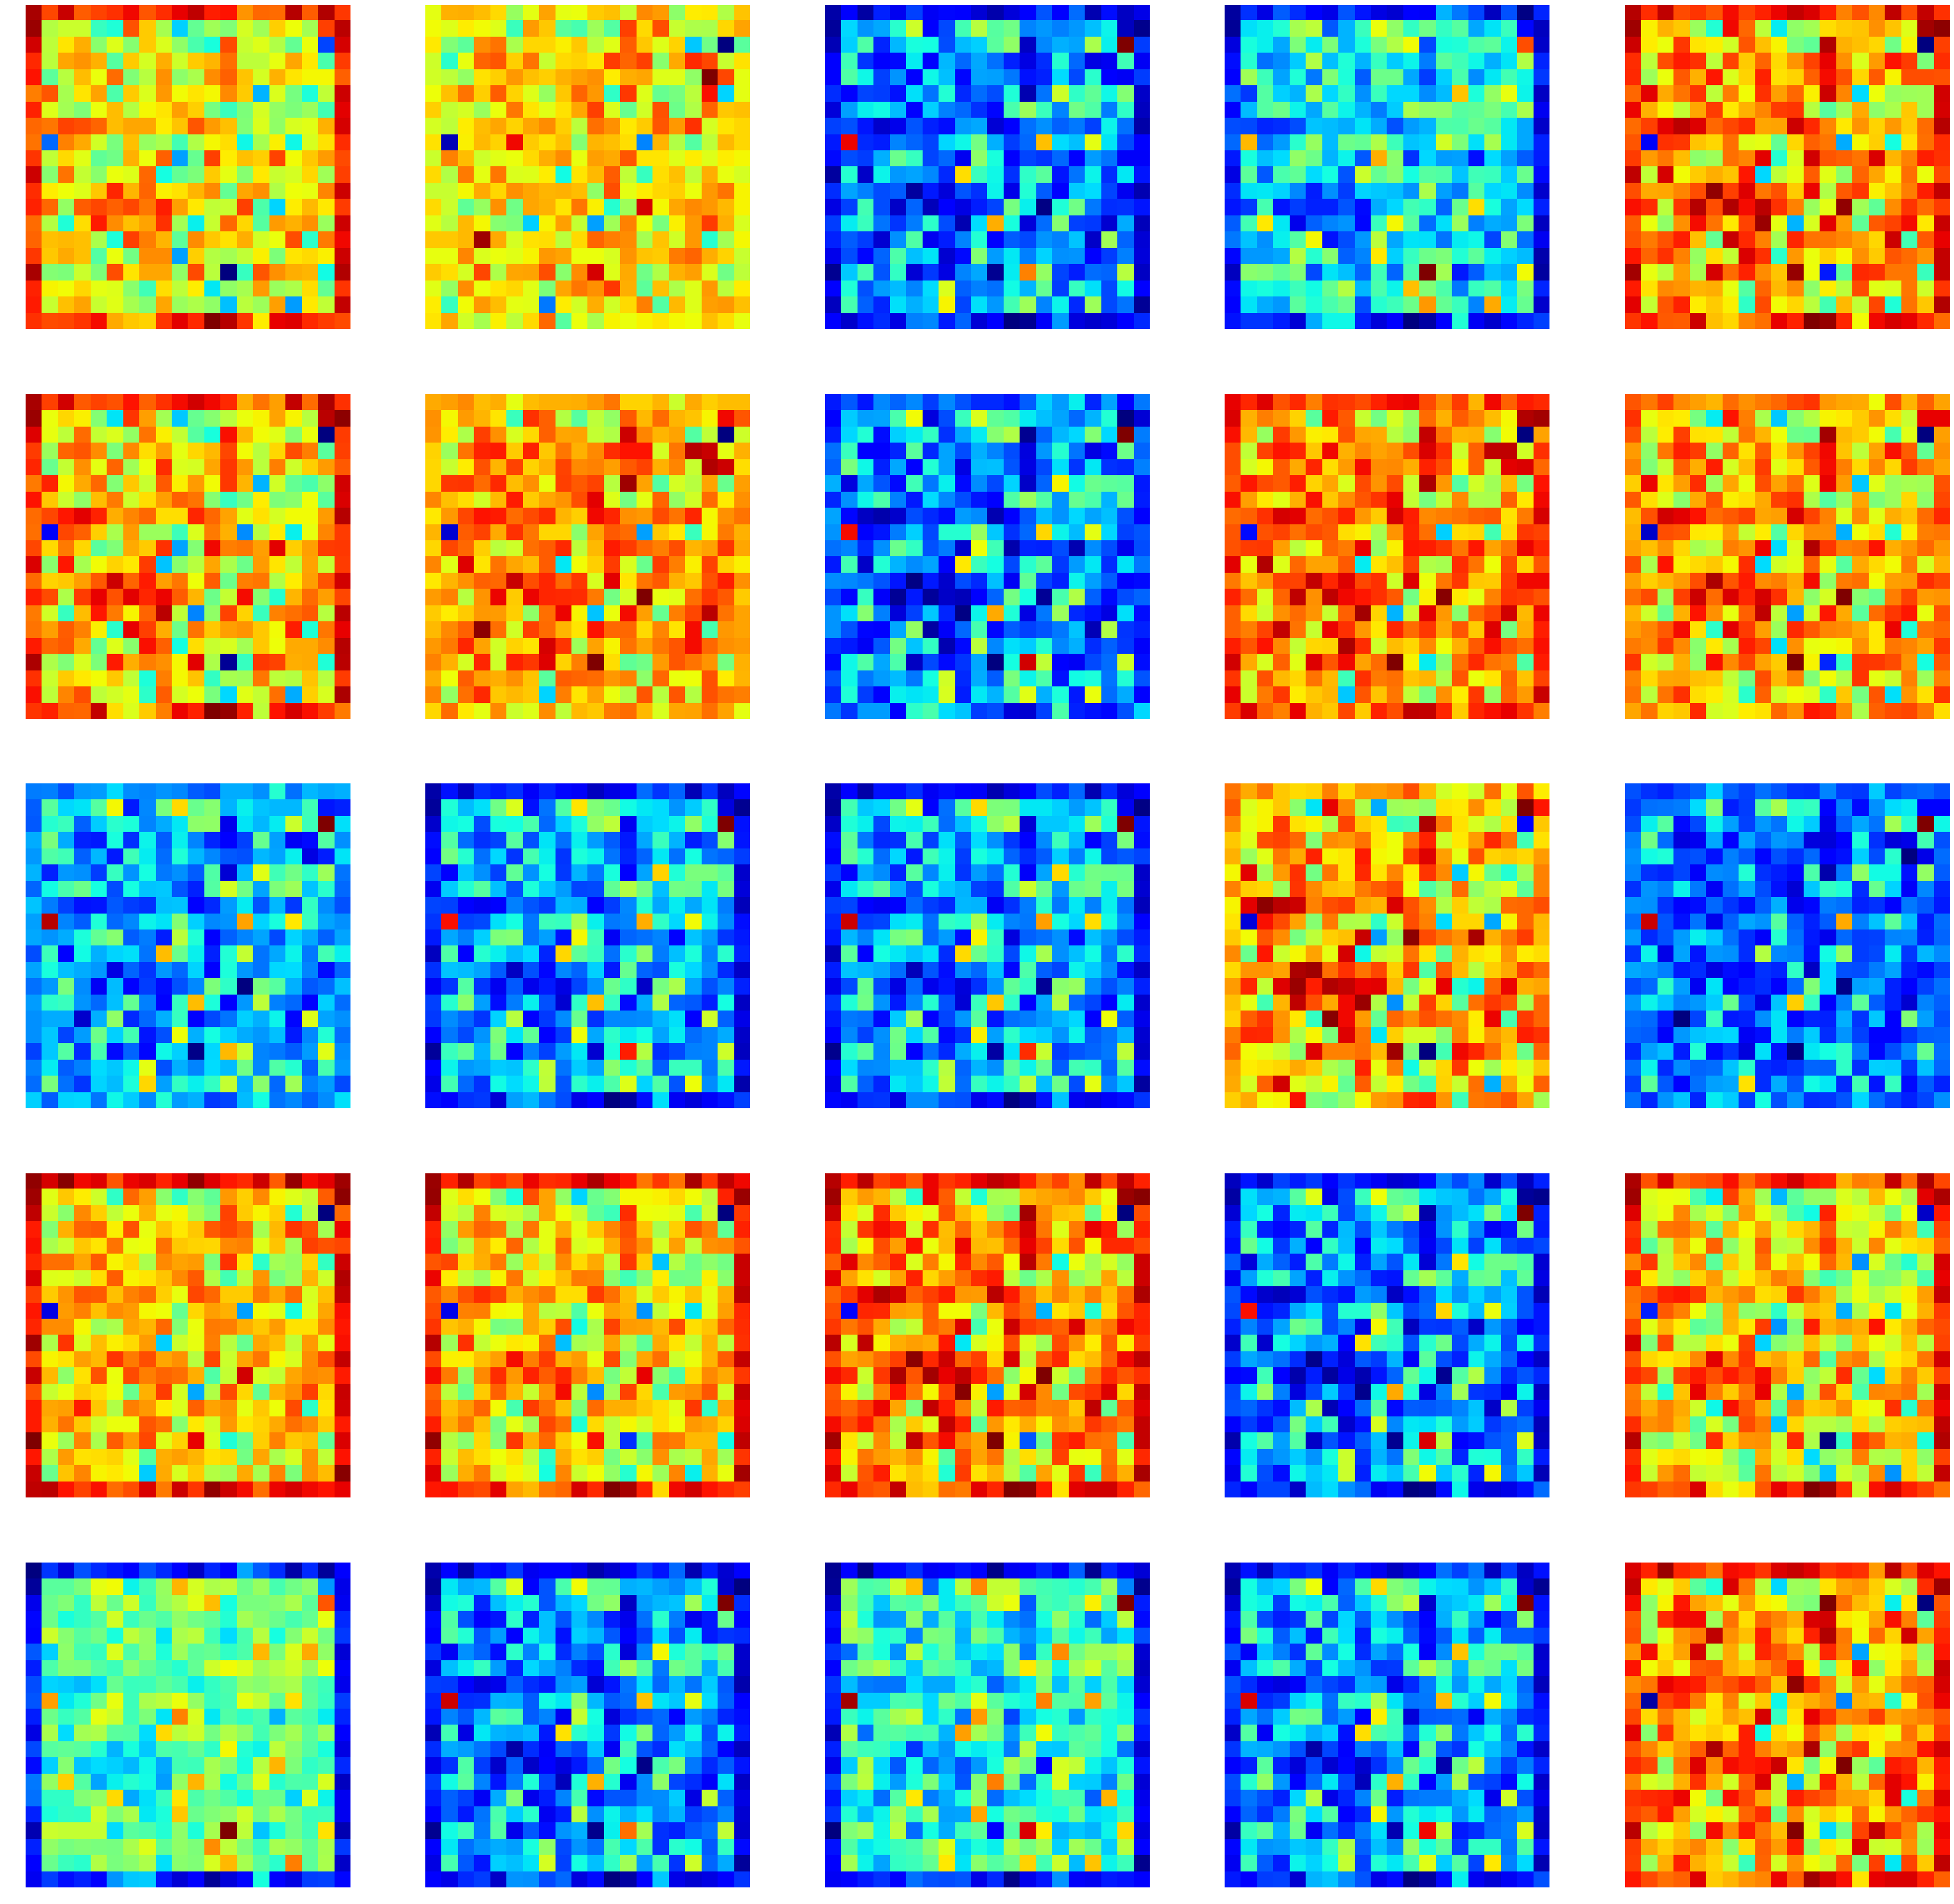

epoch 1, mean loss 7.90009987449646, std loss 0.047210620782314194


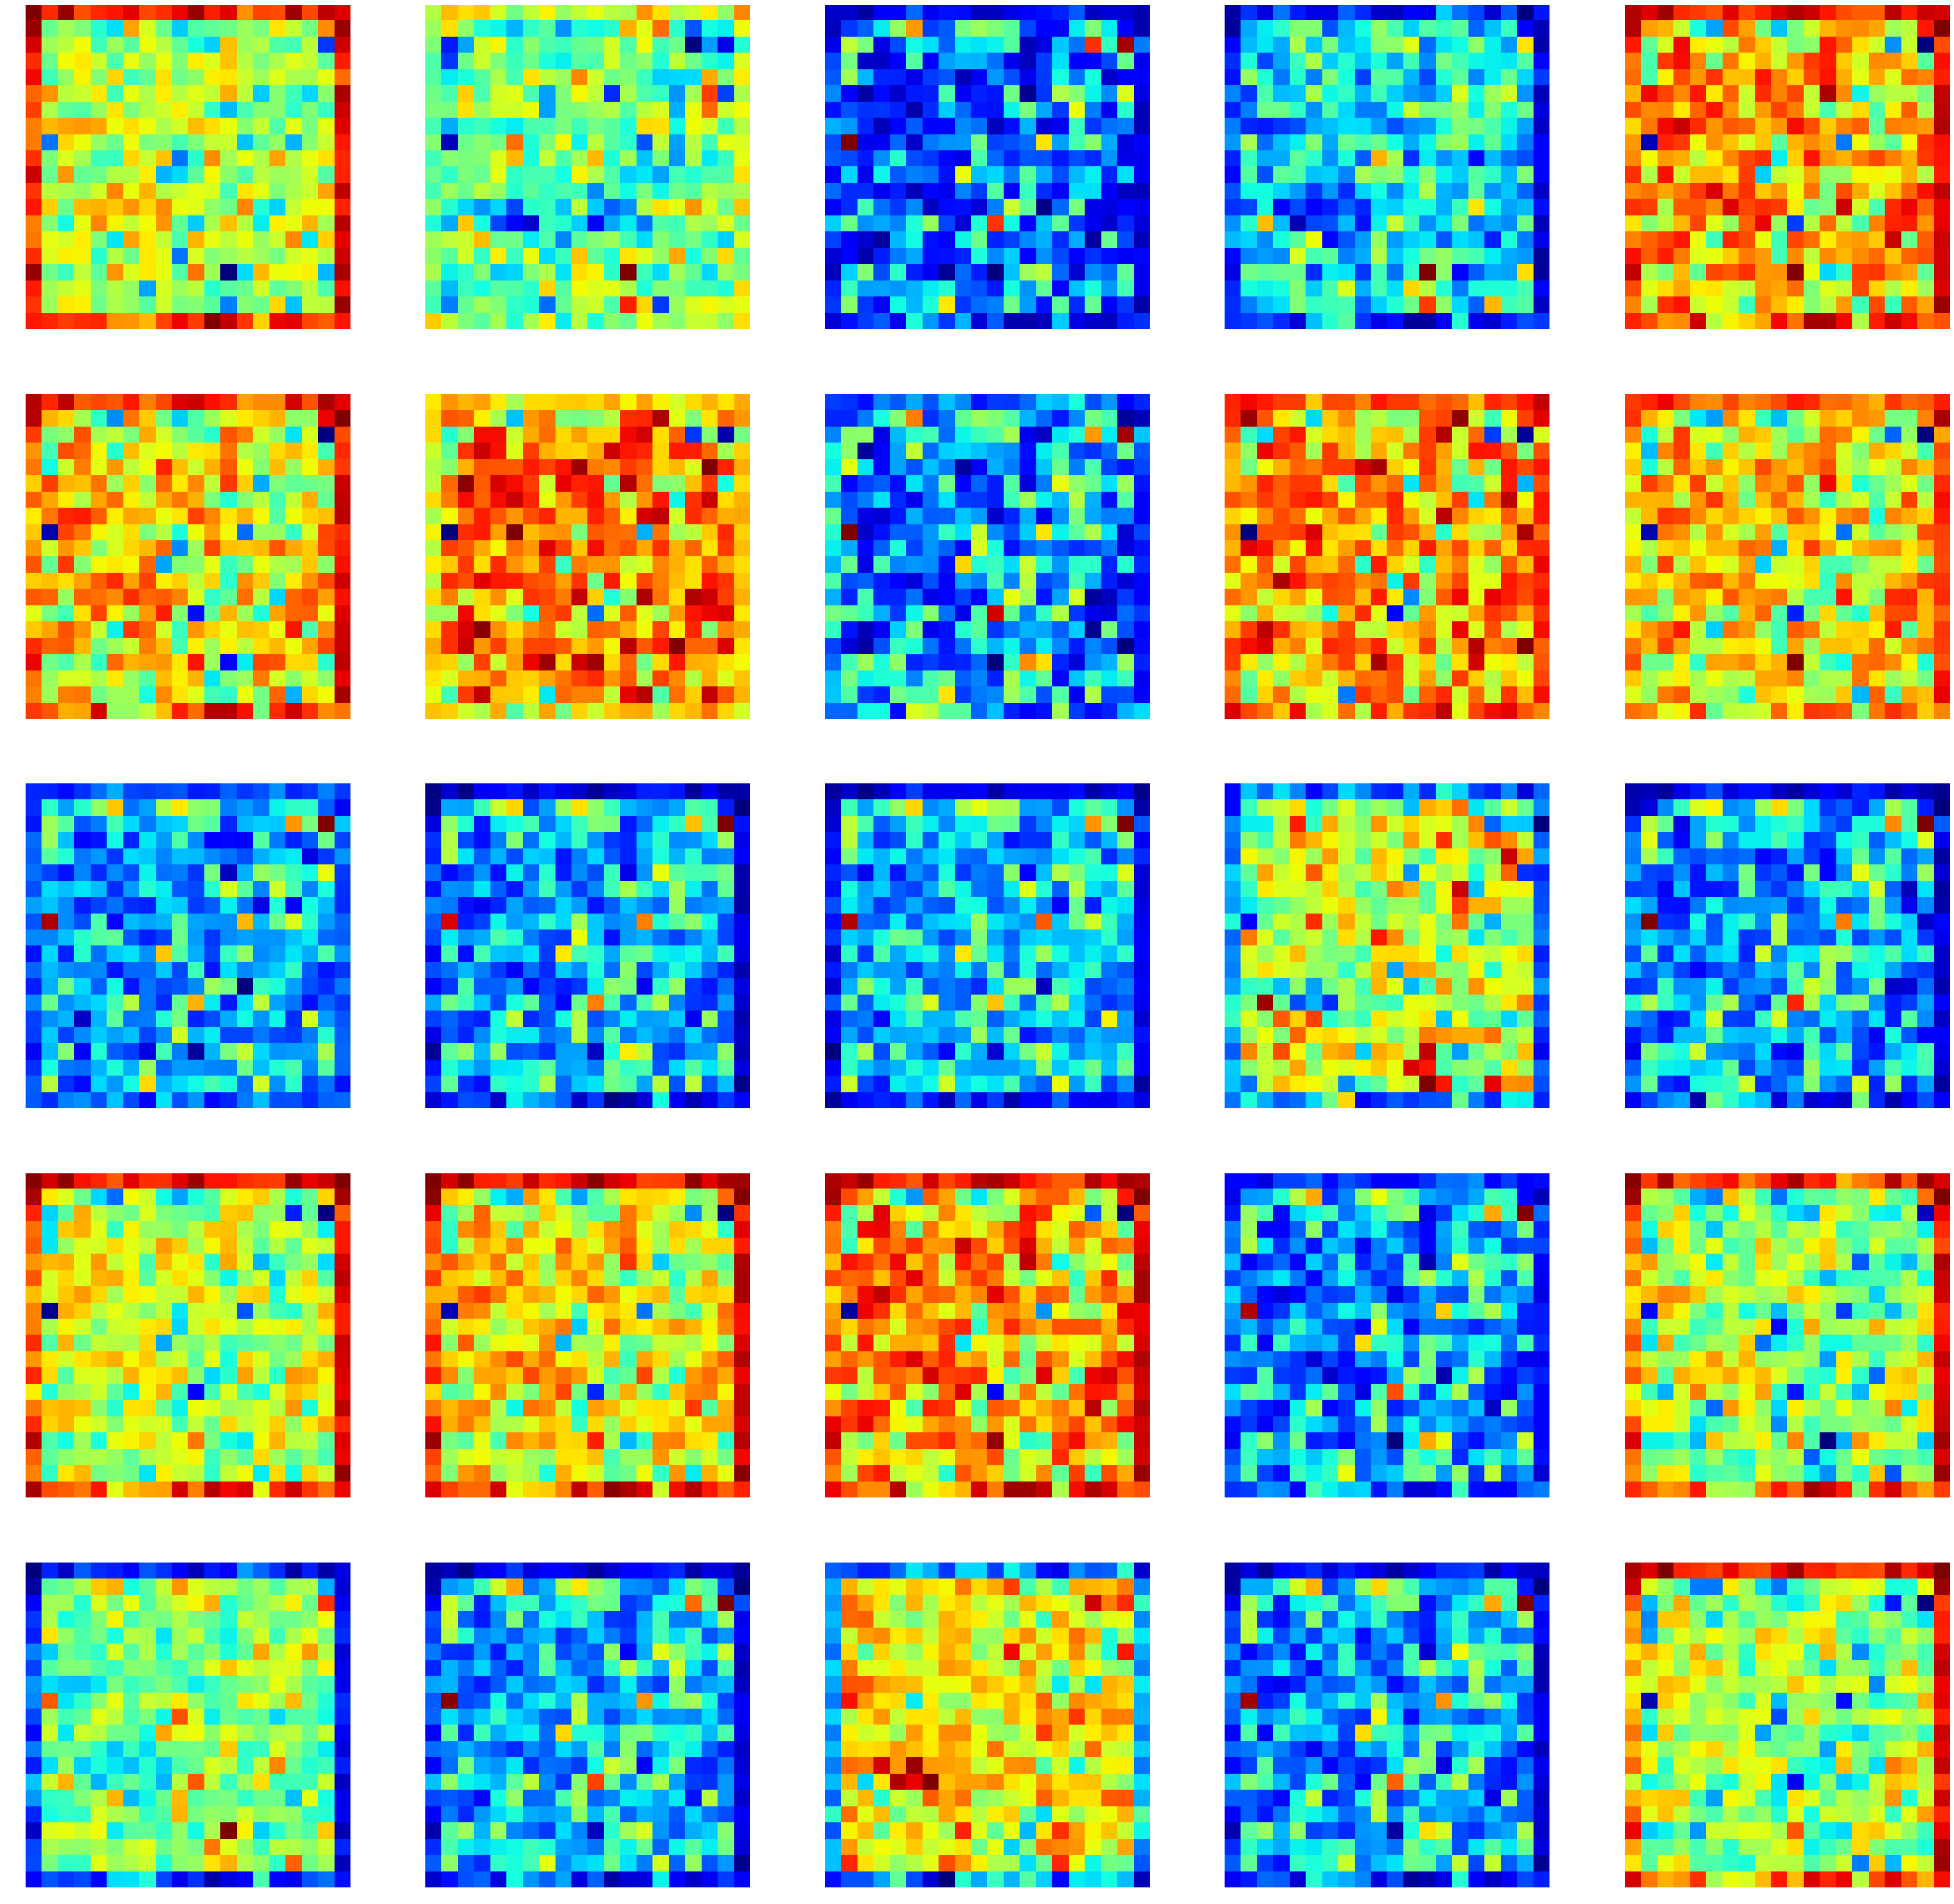

epoch 2, mean loss 7.889657808303833, std loss 0.04923018695450547


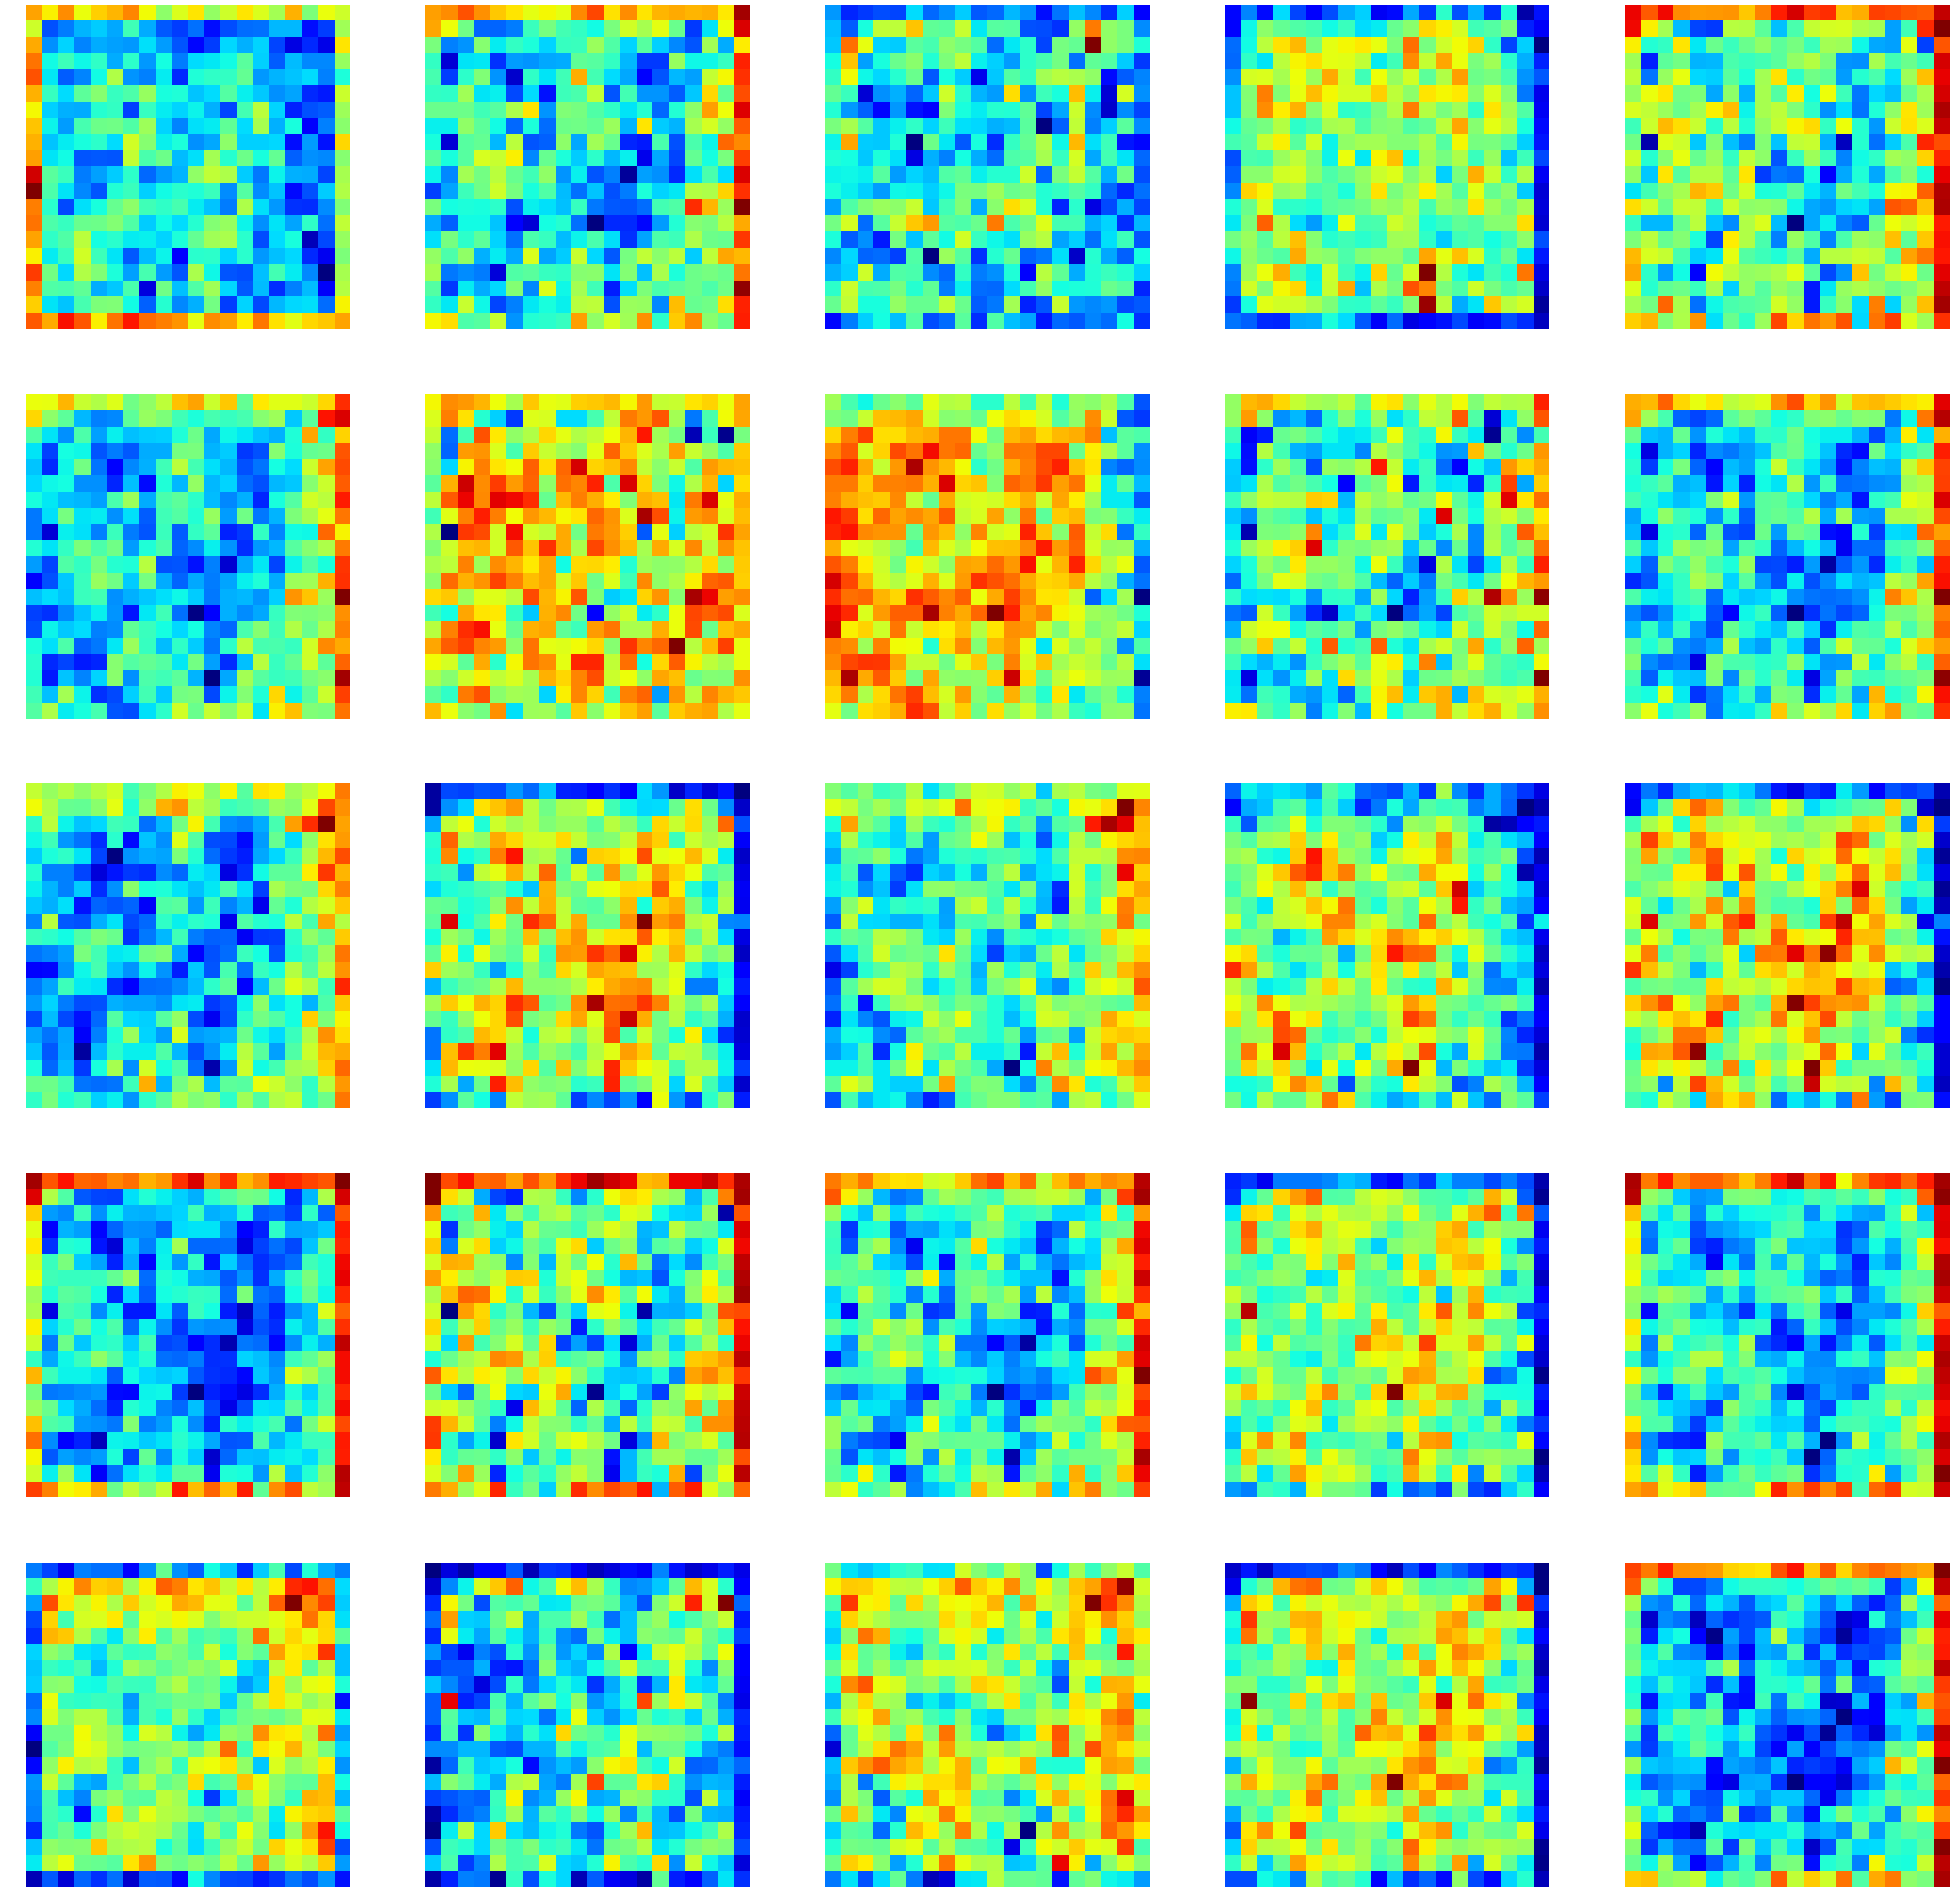

epoch 3, mean loss 7.8757195763587955, std loss 0.05365179980778629


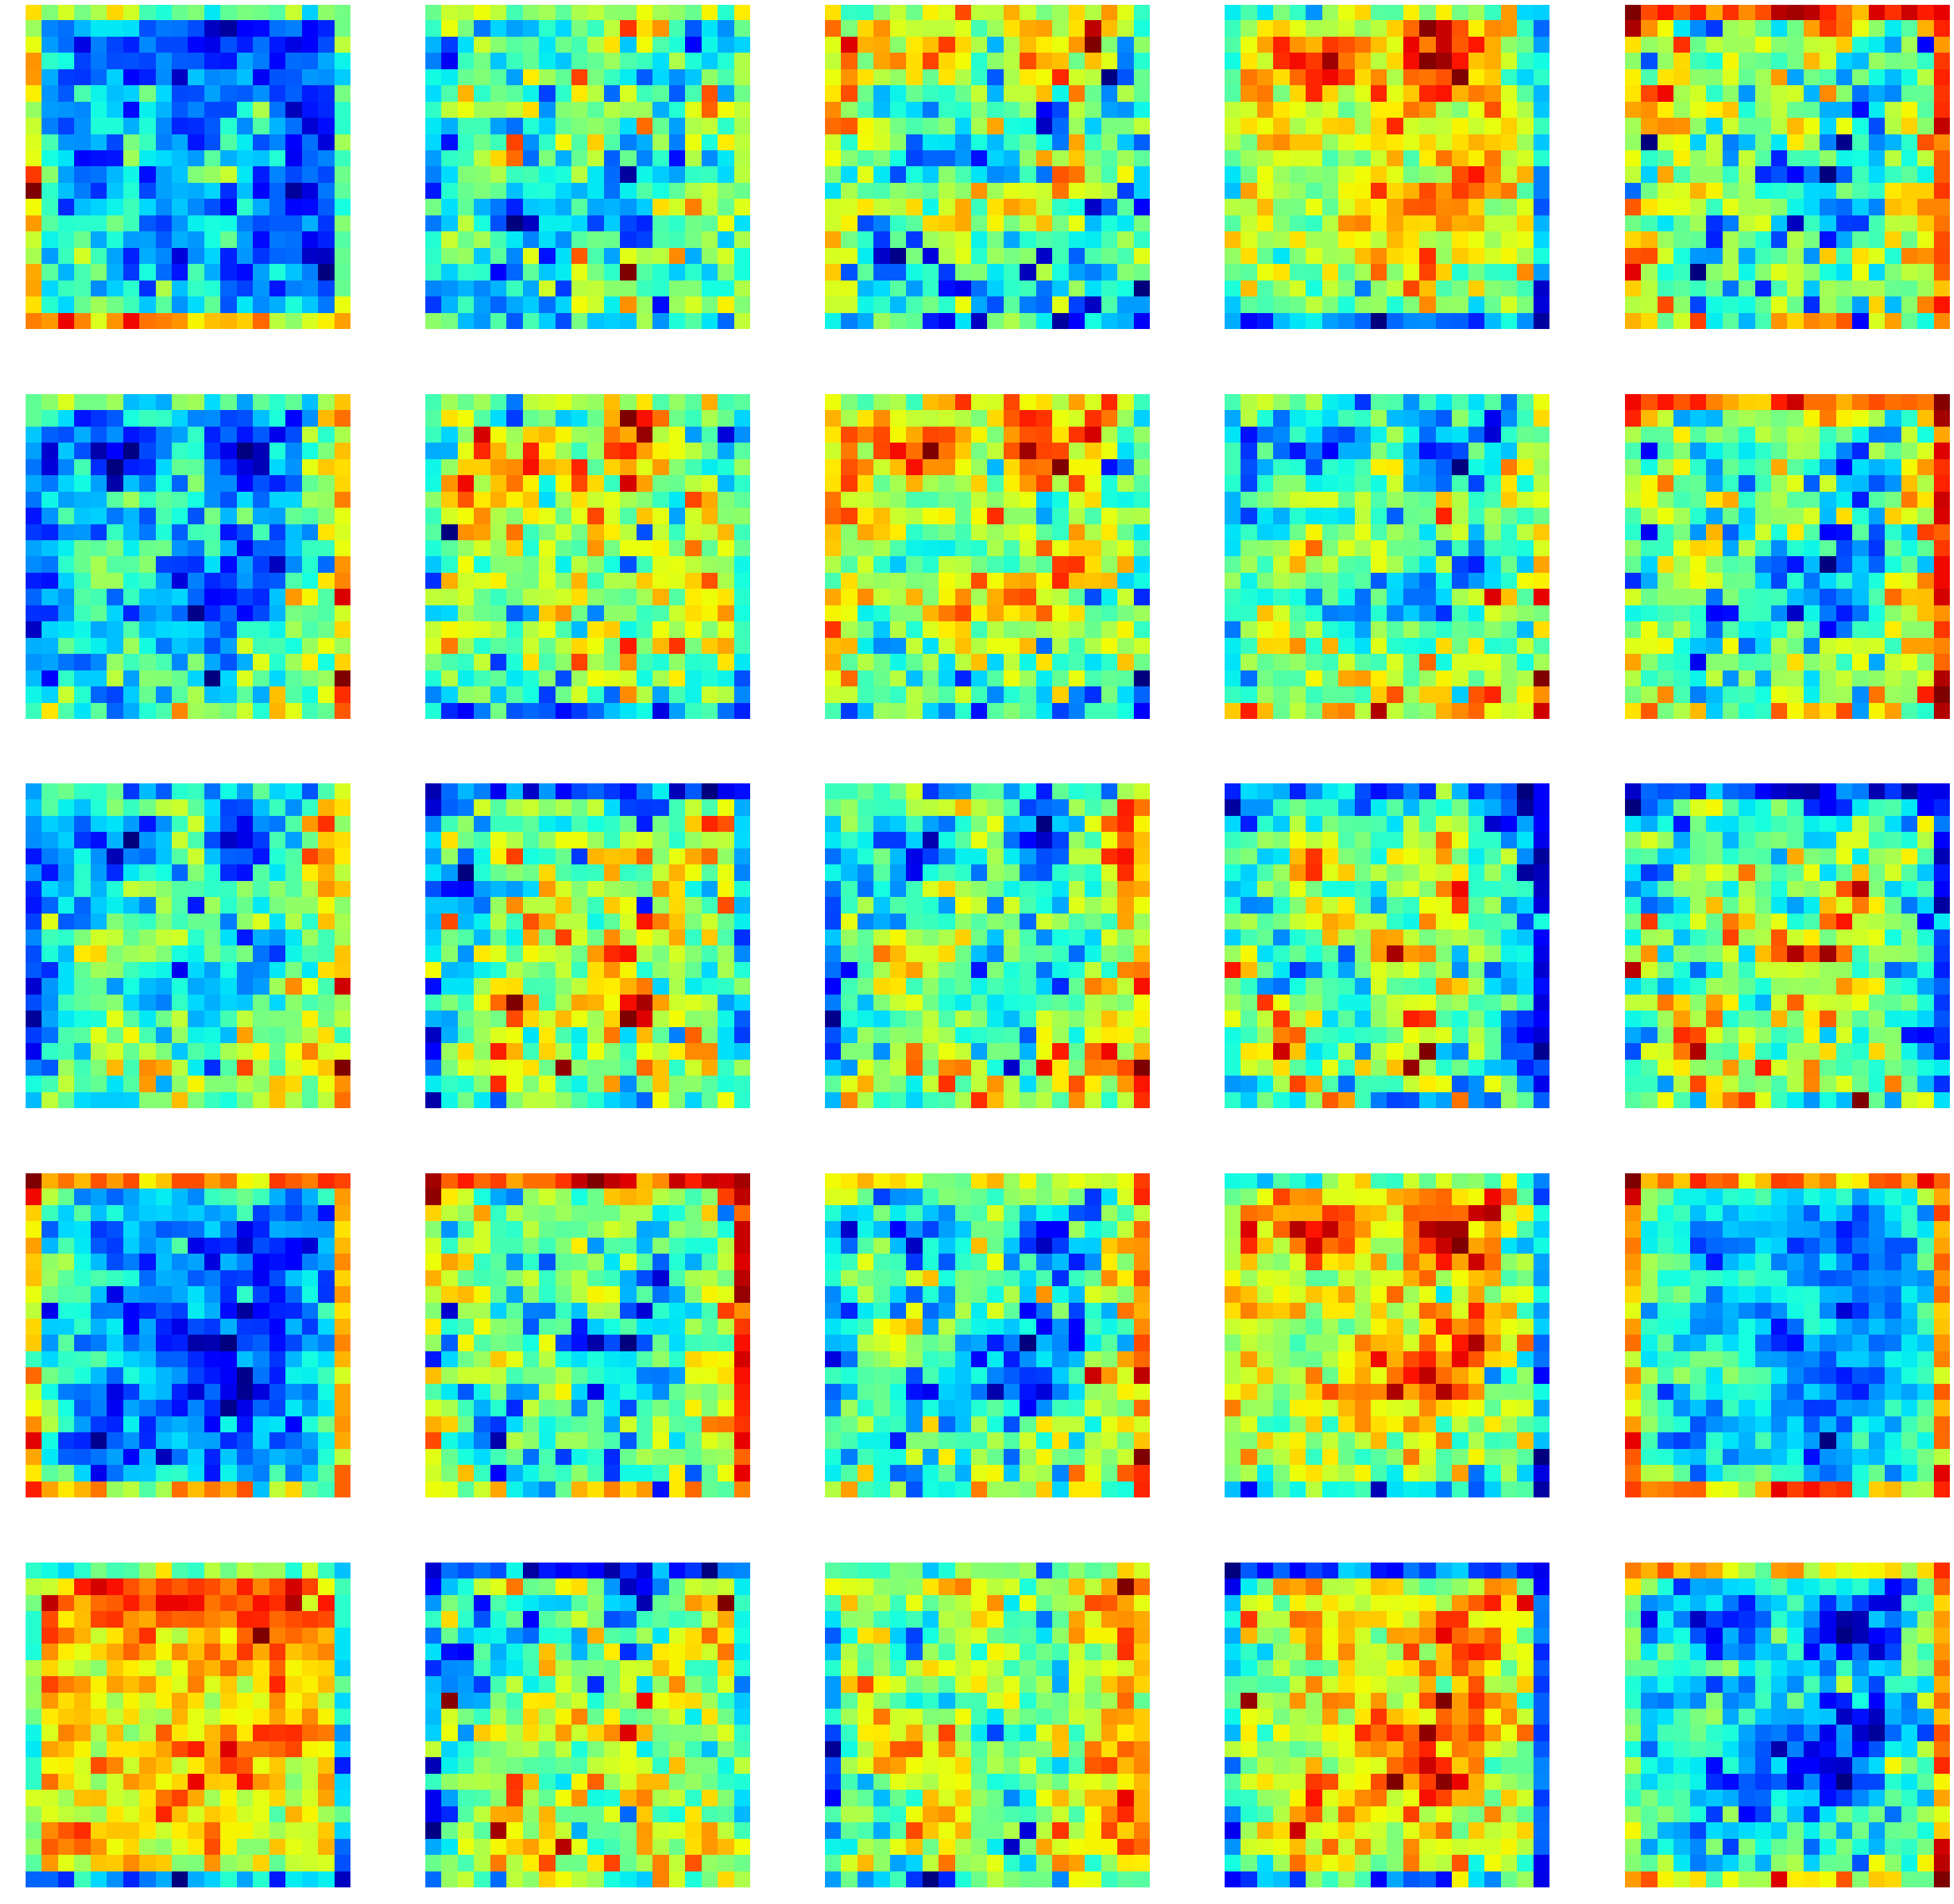

epoch 4, mean loss 7.86512069272995, std loss 0.05598445699581567


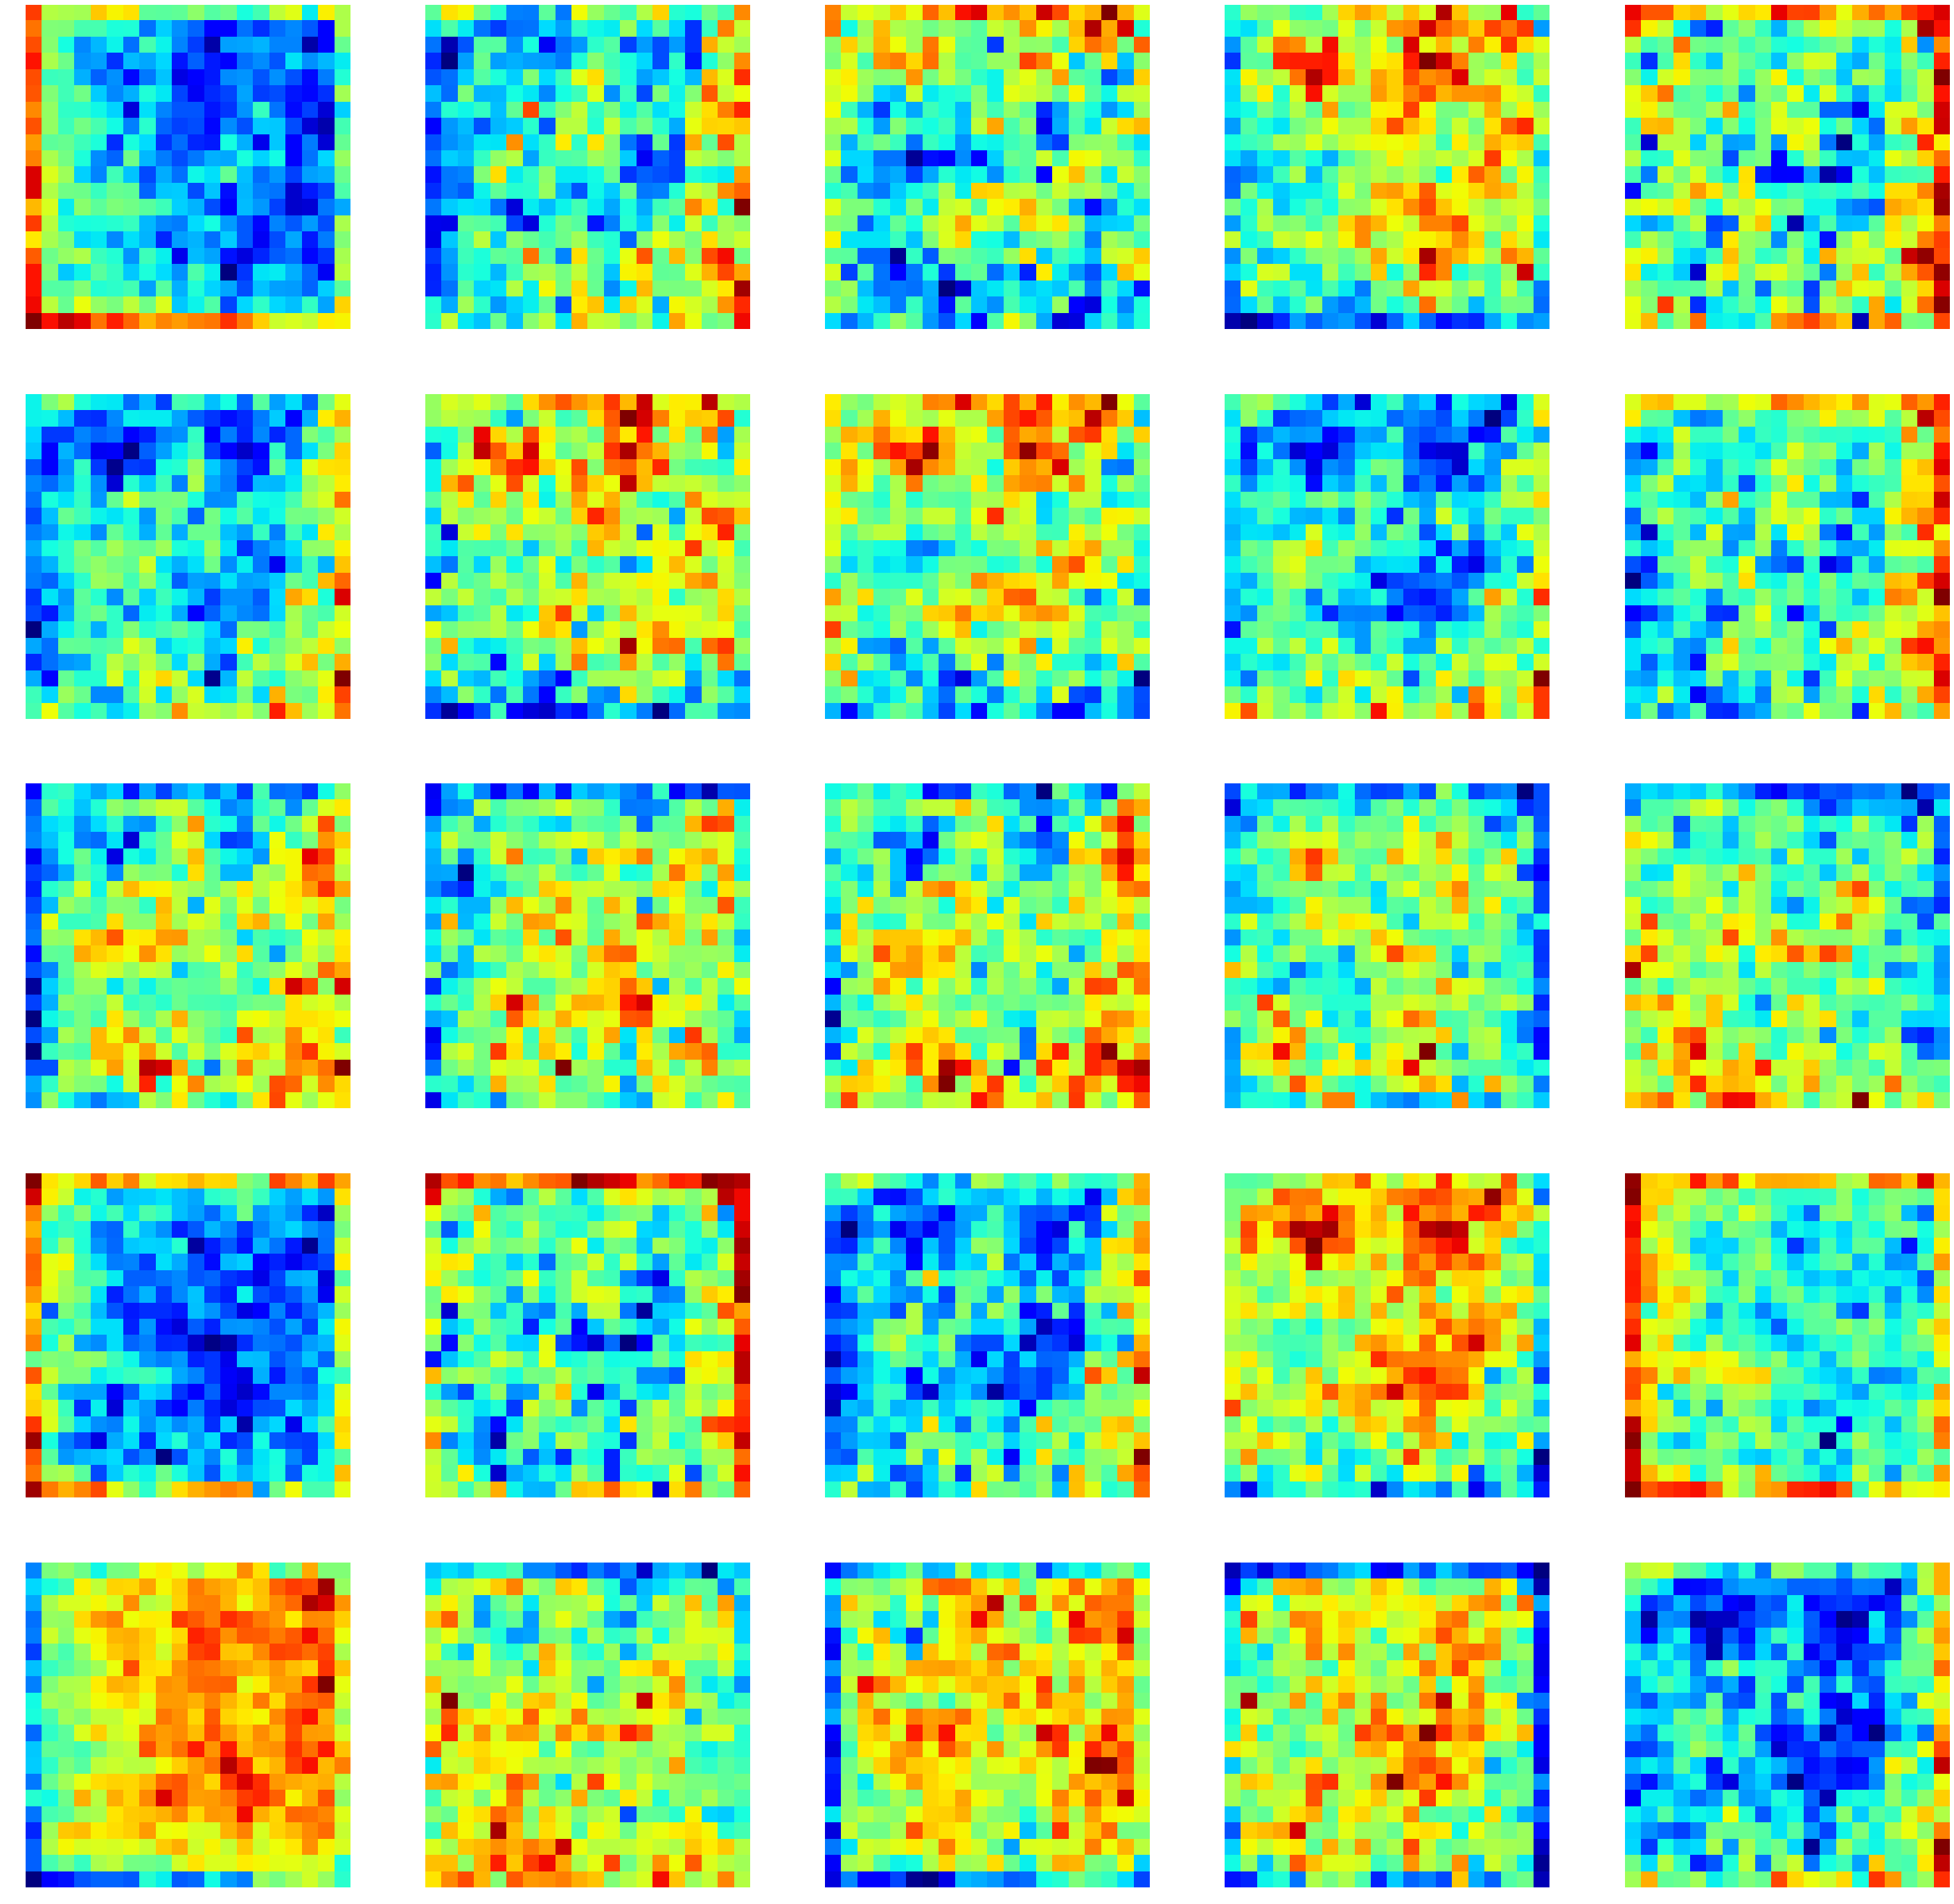

epoch 5, mean loss 7.855471837043762, std loss 0.05748694921975909


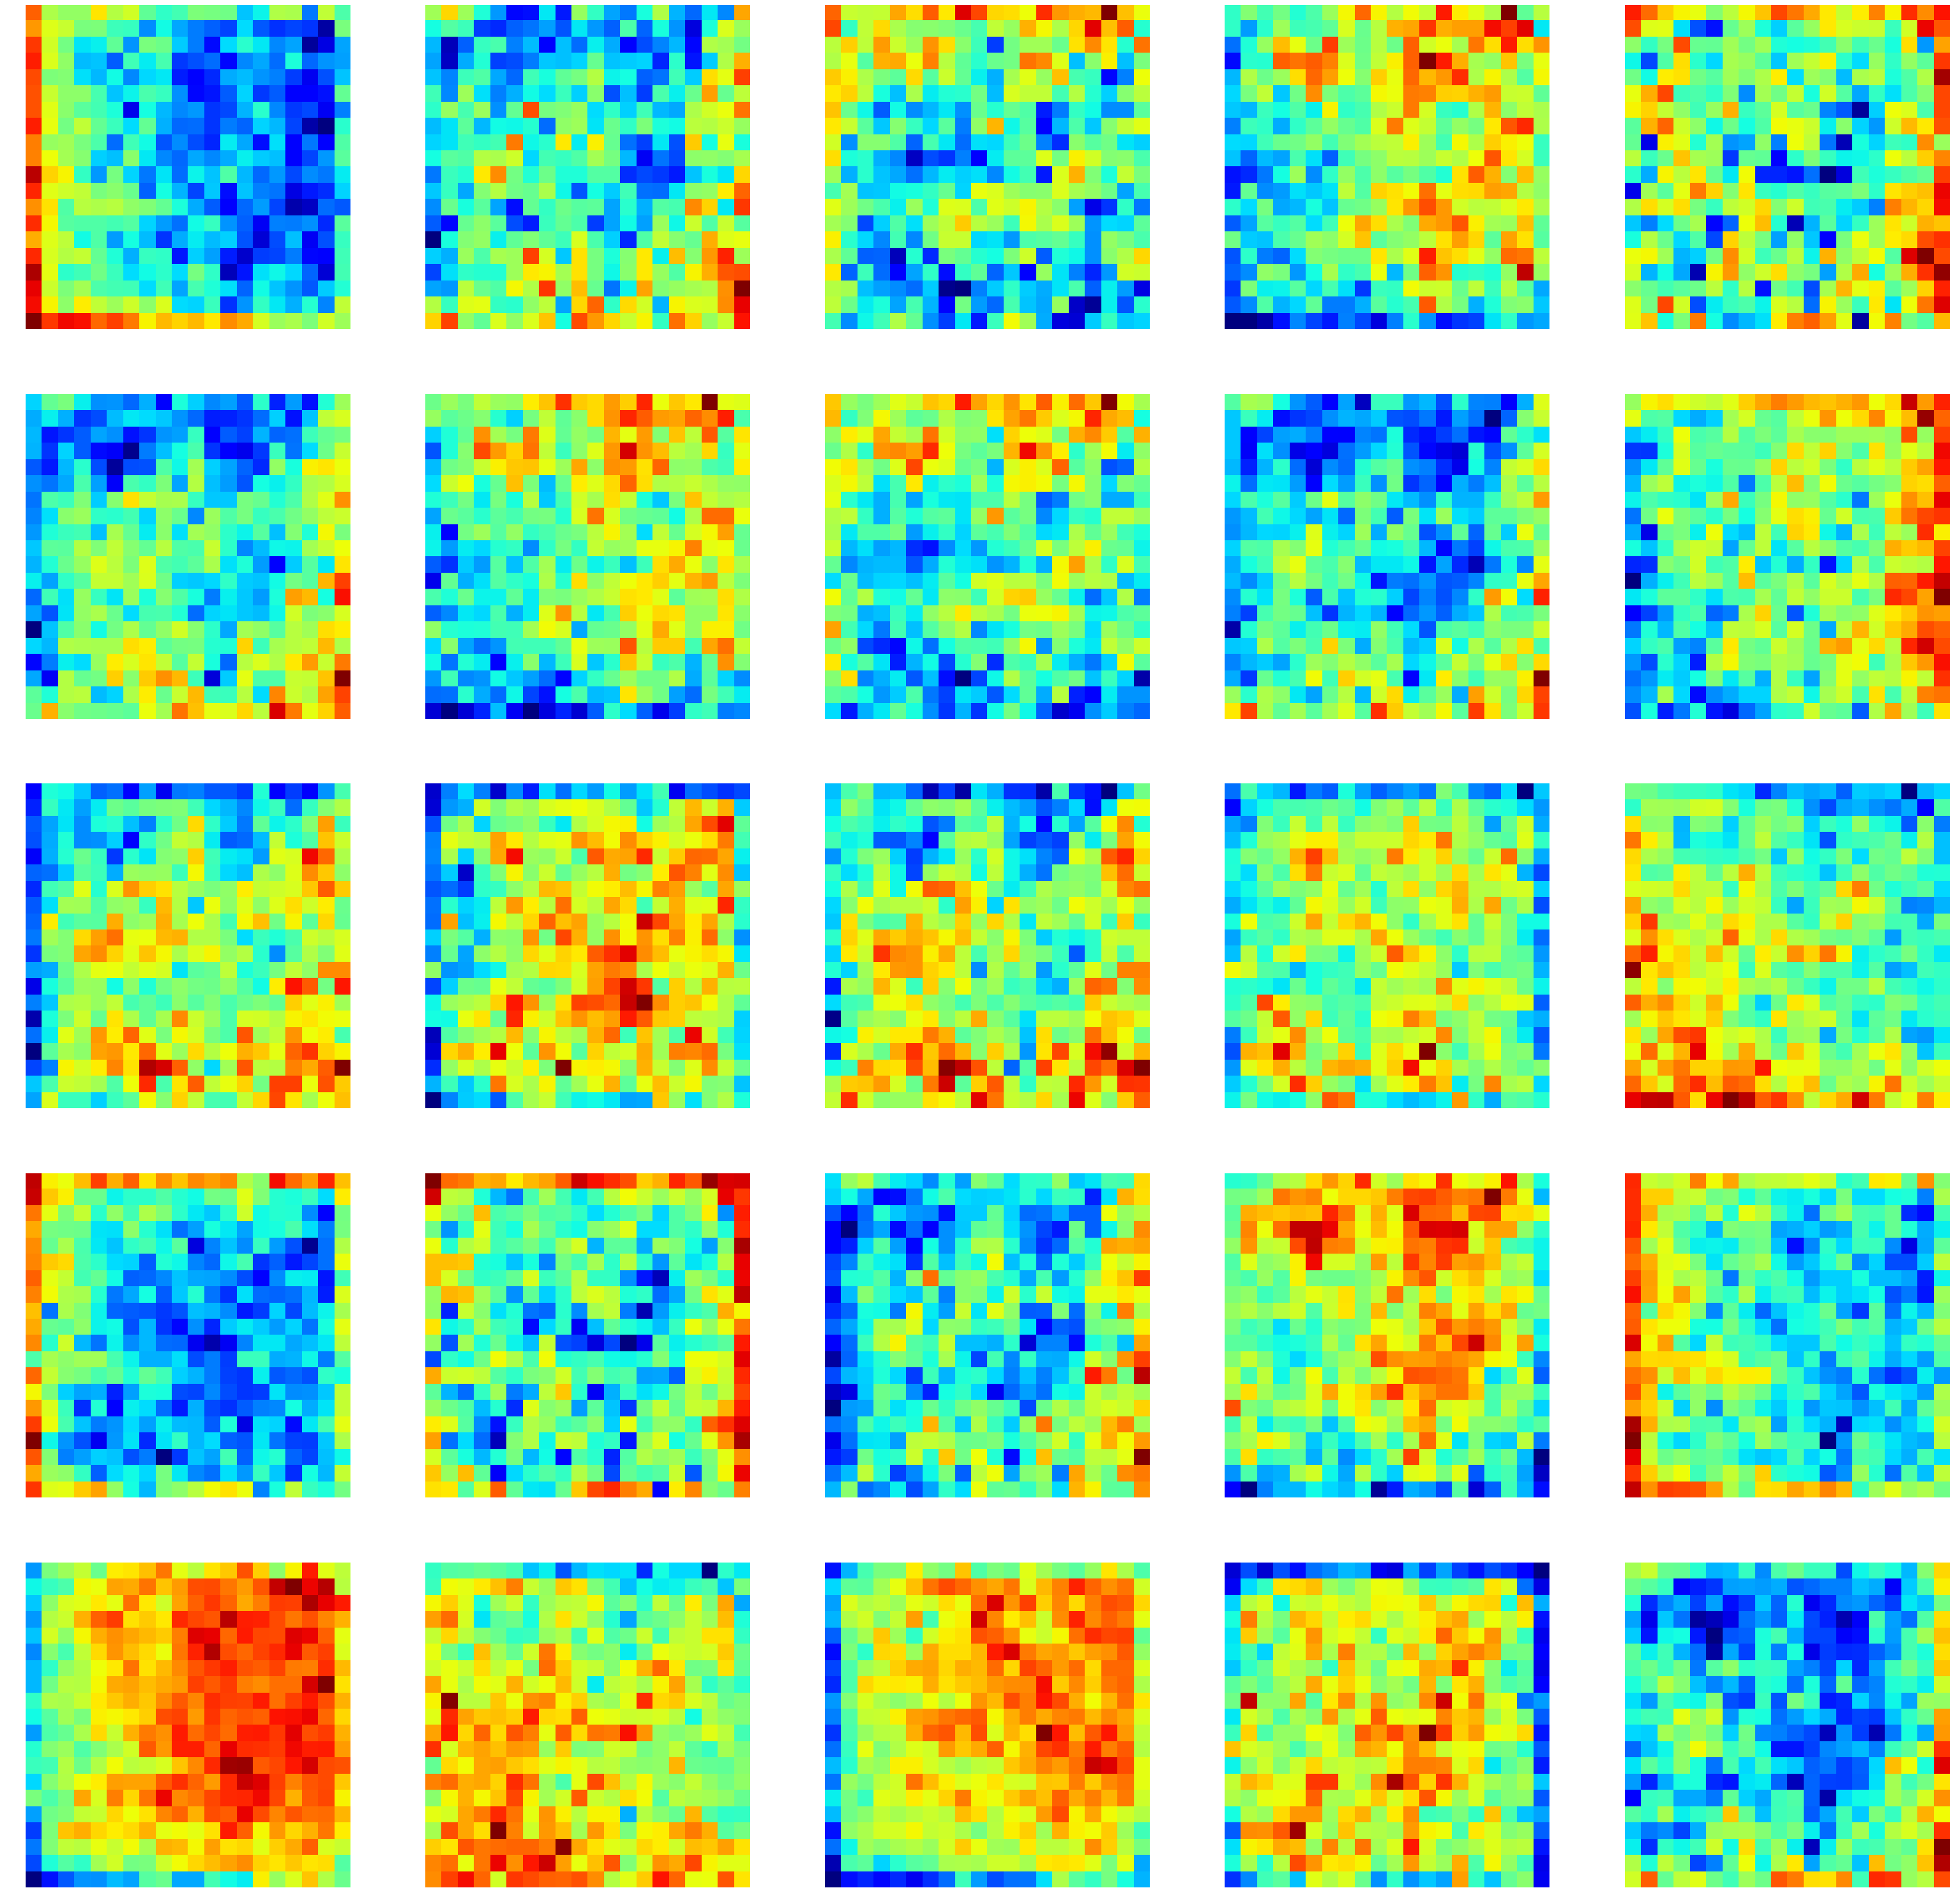

epoch 6, mean loss 7.848229109764099, std loss 0.05879235469126969


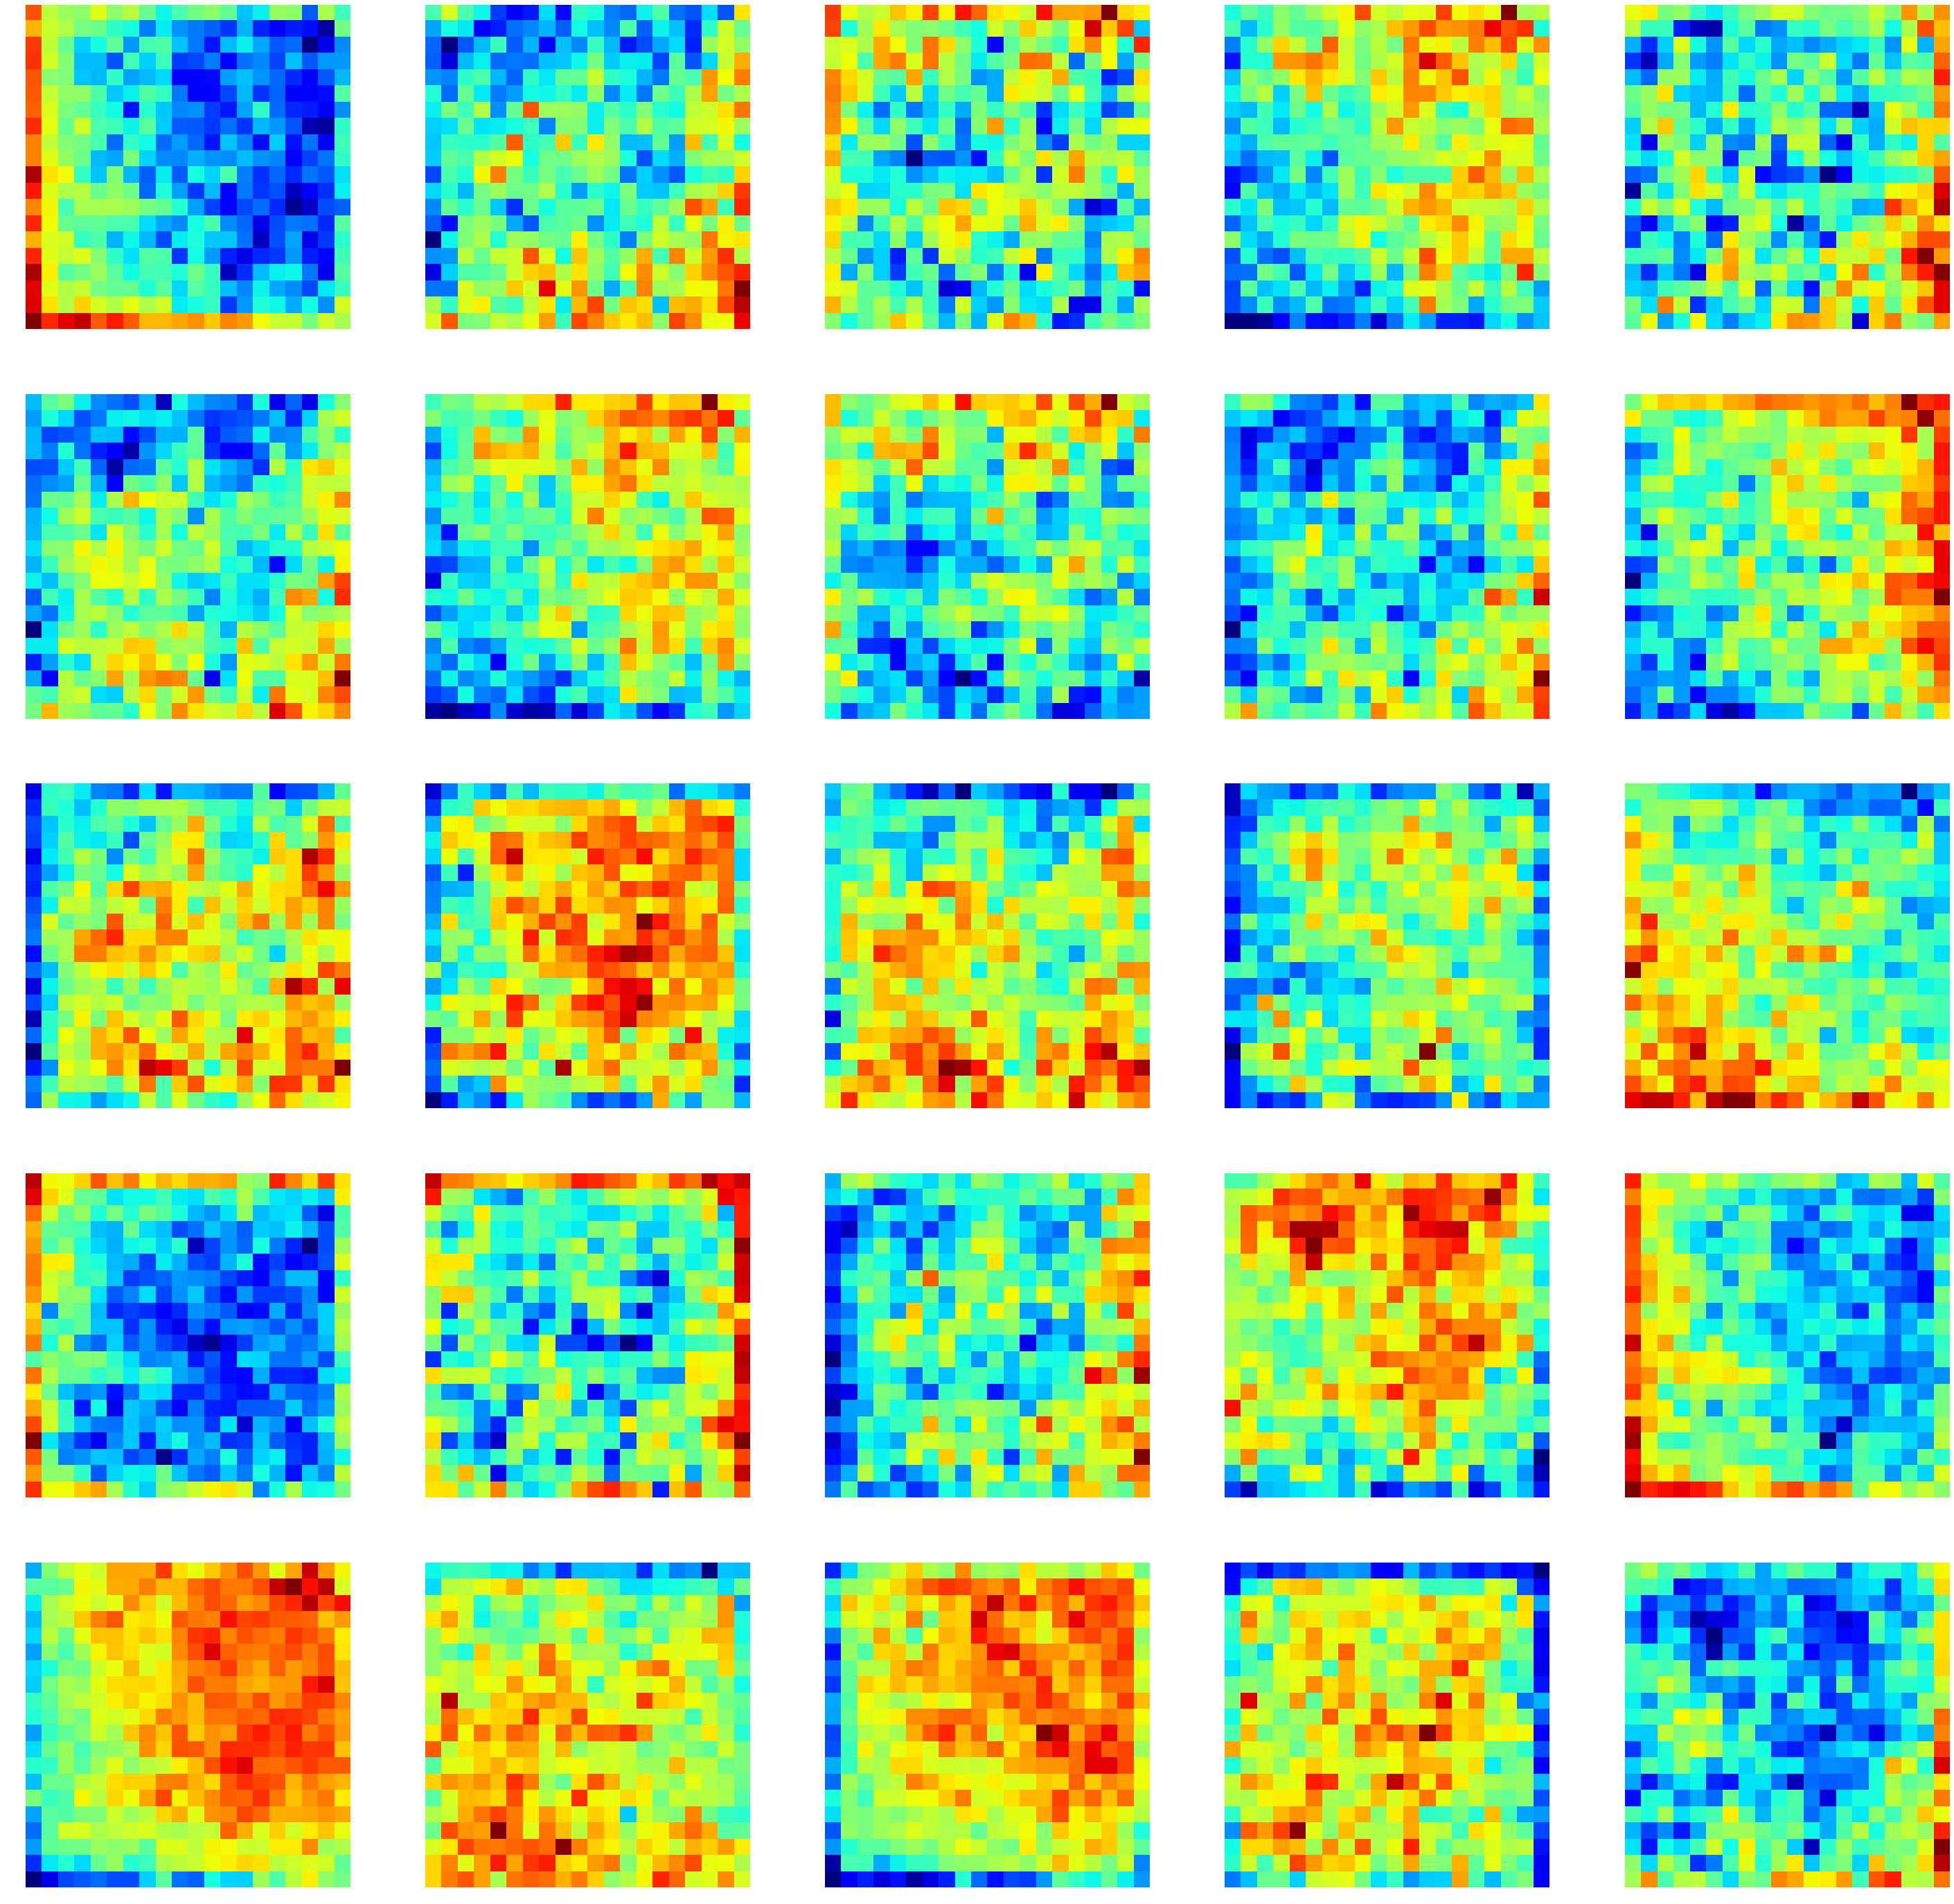

epoch 7, mean loss 7.840244942188263, std loss 0.06102294254458295


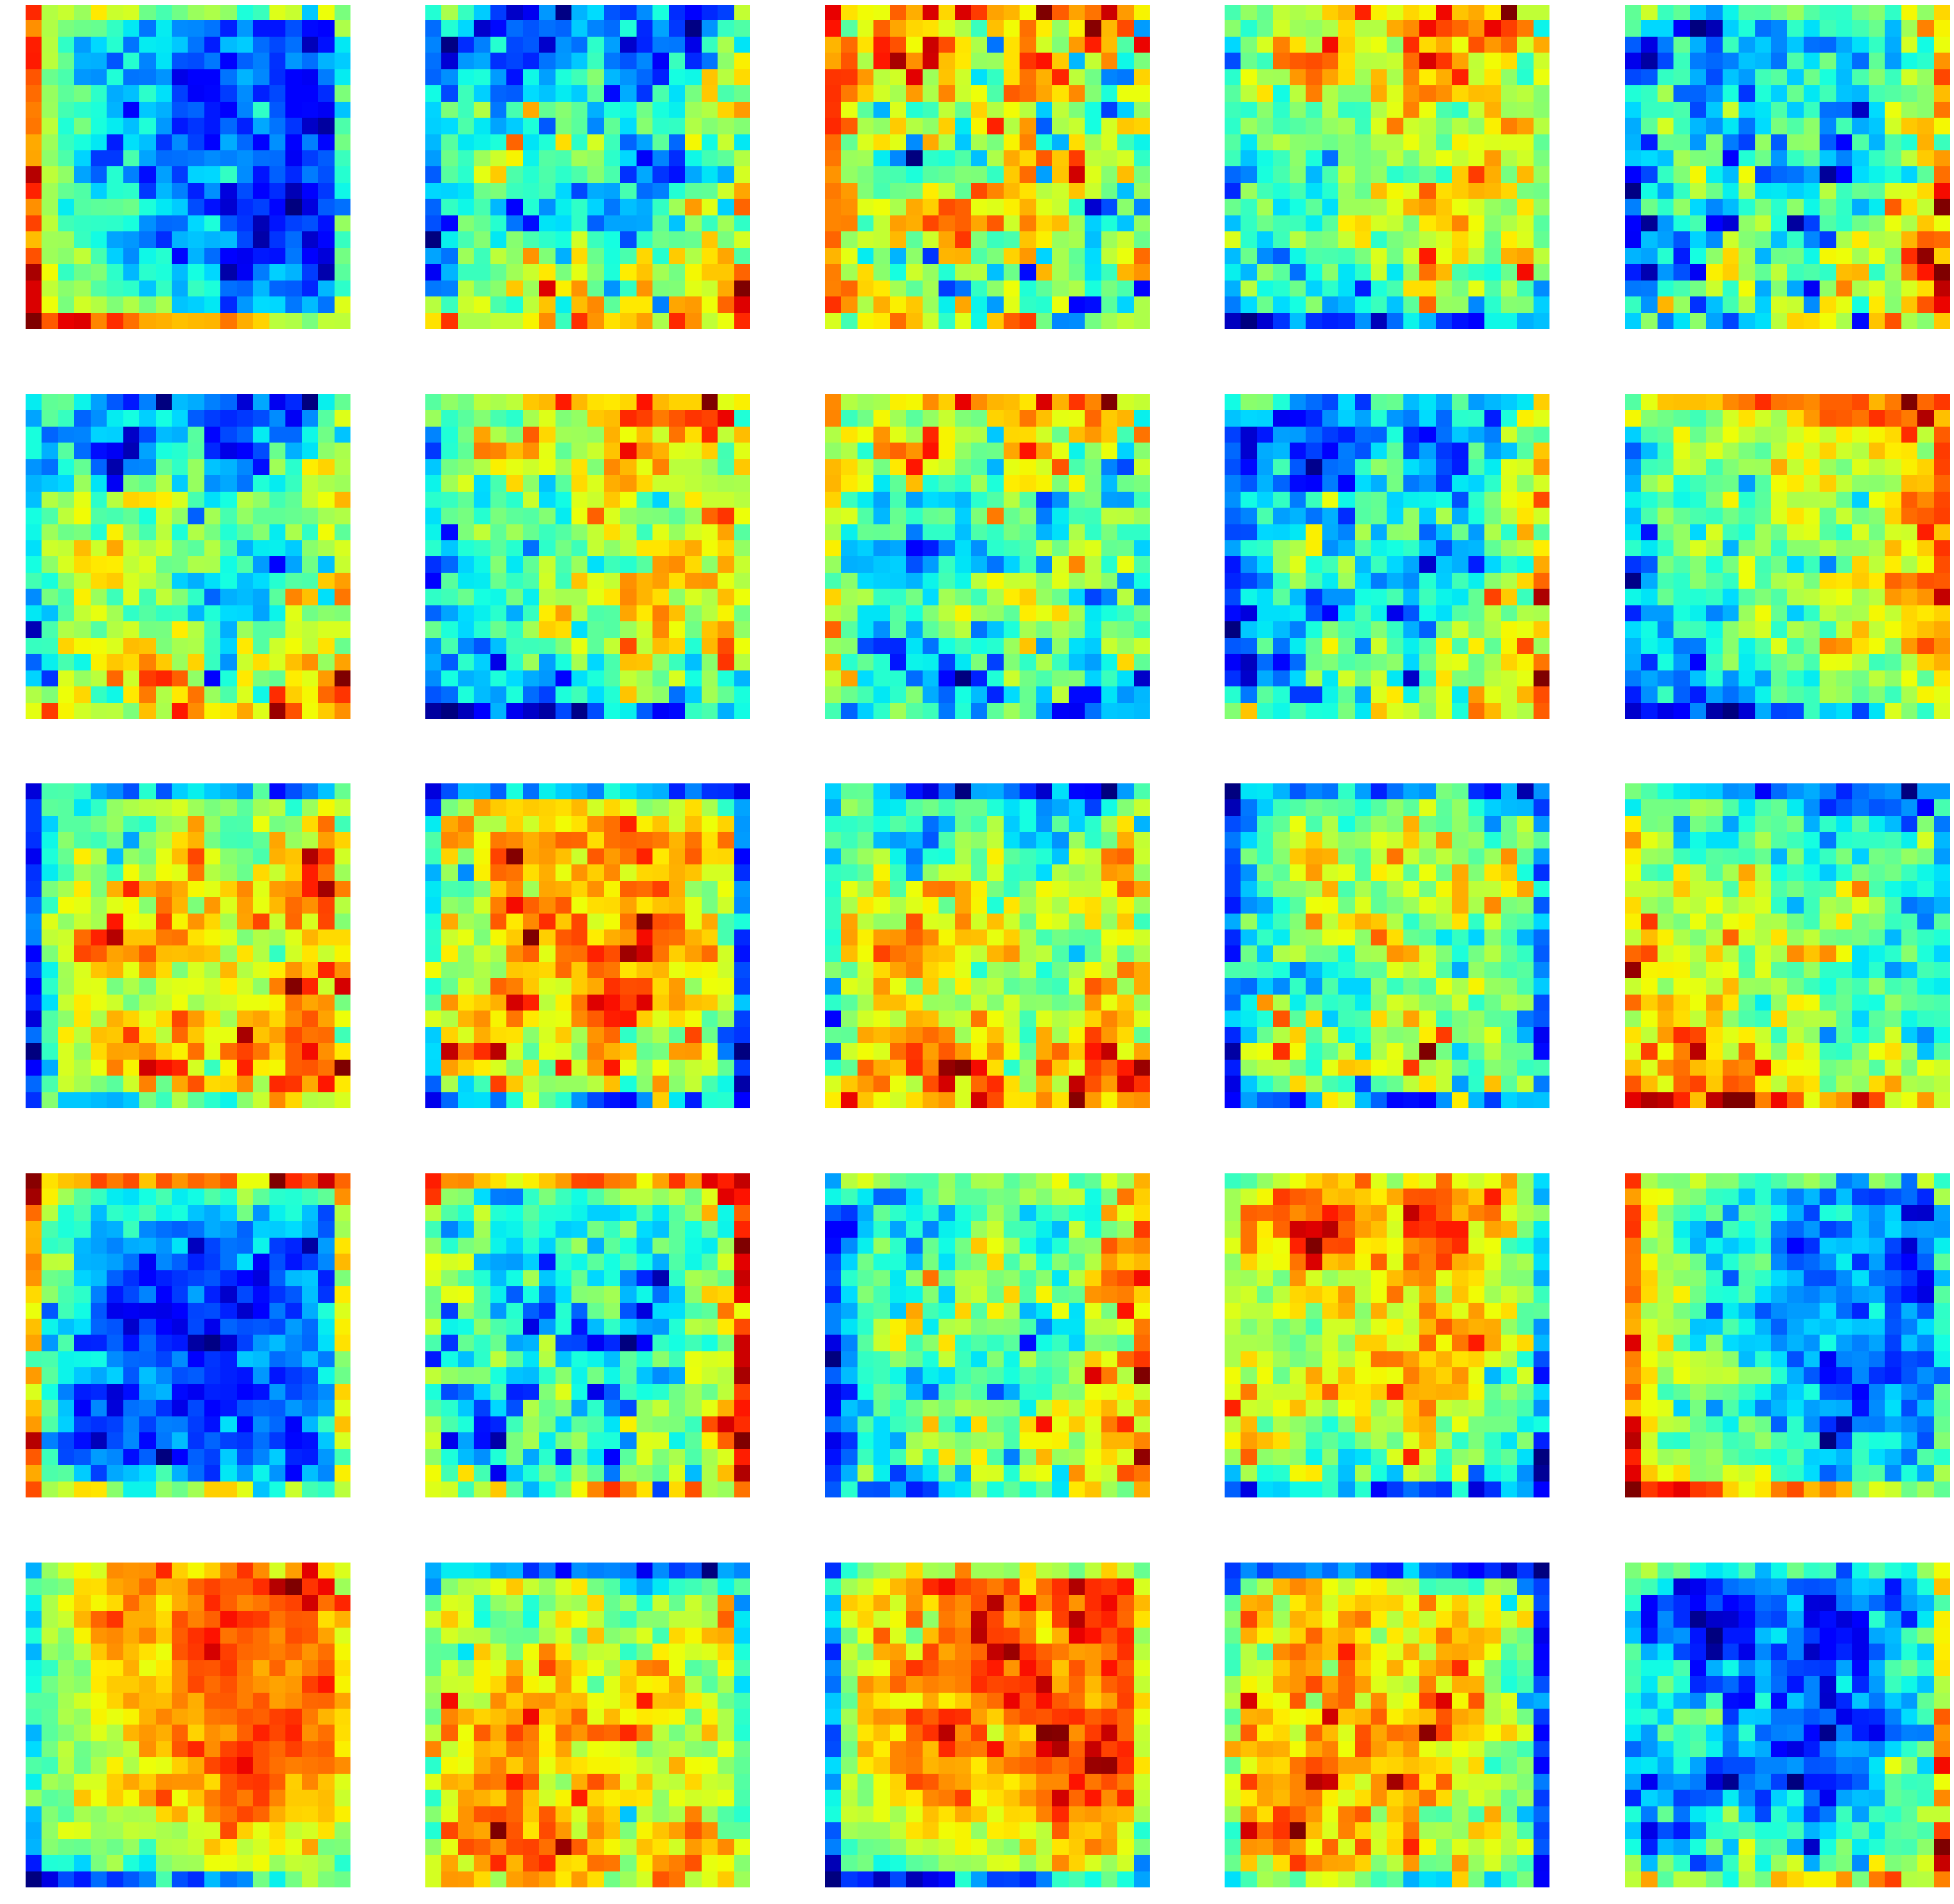

In [ ]:
losses = train_model(VNM, dataloader, place_cells, hd_cells, lr=1e-5, num_epochs=1000)
plt.plot(np.arange(len(losses)), losses)
plt.show()